## Rebalancing 
Interpolating NYC Bike Share Data to Discover Rebalancing Movement

## Import libraries and data 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Read only columns needed, parse datetime columns.

In [2]:
df = pd.read_csv('~/bikeshare/202009-citibike-tripdata.csv',\
                 usecols=['starttime','start station id','stoptime','end station id','bikeid'],\
                 parse_dates=['starttime','stoptime'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2488225 entries, 0 to 2488224
Data columns (total 5 columns):
 #   Column            Dtype         
---  ------            -----         
 0   starttime         datetime64[ns]
 1   stoptime          datetime64[ns]
 2   start station id  int64         
 3   end station id    int64         
 4   bikeid            int64         
dtypes: datetime64[ns](2), int64(3)
memory usage: 94.9 MB


### Ghost Riders
Find bikes that were moved from one station to another without a ride in trip data

Create new dataframe `dfbike` sorted by `bikeid` and `starttime`.<br>
Note that the `end station id` for one ride is the `start station id` for the _next_.

In [4]:
dfbike=df.sort_values(by=['bikeid','starttime'])
dfbike.head(10)

,starttime,stoptime,start station id,end station id,bikeid
15101,2020-09-01 10:47:30.108,2020-09-01 10:54:27.793,284,388,14529
49062,2020-09-01 17:55:27.418,2020-09-01 18:30:47.464,388,480,14529
54963,2020-09-01 18:33:00.474,2020-09-01 18:56:19.674,480,284,14529
59248,2020-09-01 19:02:14.153,2020-09-01 19:06:24.328,284,336,14529
74846,2020-09-01 22:47:55.442,2020-09-01 22:52:29.530,336,247,14529
89097,2020-09-02 11:10:19.996,2020-09-02 11:28:45.866,247,229,14529
91012,2020-09-02 11:52:11.166,2020-09-02 11:56:29.728,229,229,14529
142109,2020-09-02 21:31:39.126,2020-09-02 21:42:00.724,229,445,14529
151933,2020-09-03 07:39:42.757,2020-09-03 07:44:41.909,445,3263,14529
153821,2020-09-03 08:09:26.875,2020-09-03 08:14:59.110,3263,432,14529


Create an "empty" one row dataframe to use as an offset 

In [5]:
offset = pd.DataFrame({'starttime': pd.to_datetime('2010-09-01'), 'start station id':0,\
                       'stoptime': pd.to_datetime('2010-09-01'),'end station id':0,'bikeid':0},index=[0])

Create two new data frames `dfbike1` with the offset first, `dfbike2` with the offset last 

In [6]:
dfbike1 = pd.concat([offset,dfbike]).reset_index(drop=True)
dfbike2 = pd.concat([dfbike,offset]).reset_index(drop=True)

Concatentate the two dataframes side-by-side 

In [7]:
dfbike = pd.concat ([dfbike1[['bikeid','stoptime','end station id']]\
                   ,dfbike2[['bikeid','starttime','start station id']] ],\
                    axis=1 )

Now each row shows the end of one trip and the start of the next.  
This is the time the bike spends at the station between rides.

In [8]:
dfbike.head()

,bikeid,stoptime,end station id,bikeid,starttime,start station id
0,0,2010-09-01 00:00:00.000,0,14529,2020-09-01 10:47:30.108,284
1,14529,2020-09-01 10:54:27.793,388,14529,2020-09-01 17:55:27.418,388
2,14529,2020-09-01 18:30:47.464,480,14529,2020-09-01 18:33:00.474,480
3,14529,2020-09-01 18:56:19.674,284,14529,2020-09-01 19:02:14.153,284
4,14529,2020-09-01 19:06:24.328,336,14529,2020-09-01 22:47:55.442,336


Look at a range of trips for one bike.  
Note that row 60 shows one trip ending at 3906 and the next one starting at 4123.  
This "ghost ride" indicates a rebalancing. 

In [9]:
dfbike[55:65]

,bikeid,stoptime,end station id,bikeid,starttime,start station id
55,14529,2020-09-09 19:32:50.351,470,14529,2020-09-09 21:32:11.784,470
56,14529,2020-09-09 21:53:22.438,410,14529,2020-09-10 16:40:28.520,410
57,14529,2020-09-10 16:51:49.008,335,14529,2020-09-10 17:40:04.686,335
58,14529,2020-09-10 18:10:18.032,3812,14529,2020-09-10 18:19:07.074,3812
59,14529,2020-09-10 18:21:12.921,3812,14529,2020-09-11 13:25:40.381,3812
60,14529,2020-09-11 13:52:09.488,3906,14529,2020-09-12 15:44:36.348,4123
61,14529,2020-09-12 16:08:25.391,499,14529,2020-09-12 16:16:40.668,499
62,14529,2020-09-12 16:28:31.910,305,14529,2020-09-12 16:52:58.746,305
63,14529,2020-09-12 16:59:35.428,3815,14529,2020-09-12 17:02:37.739,3815
64,14529,2020-09-12 17:17:34.892,265,14529,2020-09-12 17:51:13.908,265


Rename columns:  
Distinguish bike ids.  
Swap start/stop names so rebalancing move resembles a ride 

In [10]:
dfbike.columns = ['bikeid1','starttime','start station id','bikeid2','stoptime','end station id'] 

Select those rows where the bikeid hasn't change but the start/stop staion ids are different.  
That indicates a "ghost ride" for rebalancing or maintenance.

In [11]:
dfrebal = dfbike[['starttime','start station id','stoptime','end station id']].\
      loc[(dfbike.bikeid1==dfbike.bikeid2) & (dfbike['start station id'] != dfbike['end station id']) ] 

Reset the dataframe index to number rows sequentially

In [12]:
dfrebal.reset_index(drop=True, inplace=True)
dfrebal

,starttime,start station id,stoptime,end station id
0,2020-09-11 13:52:09.488,3906,2020-09-12 15:44:36.348,4123
1,2020-09-05 13:17:07.343,3762,2020-09-06 16:40:22.864,3637
2,2020-09-15 18:26:54.208,3361,2020-09-16 11:51:52.253,3368
3,2020-09-16 11:55:02.568,3403,2020-09-17 15:36:44.011,3143
4,2020-09-03 12:04:03.602,3744,2020-09-03 14:41:22.388,501
...,...,...,...,...
39555,2020-09-29 23:29:07.872,247,2020-09-30 22:48:23.886,349
39556,2020-09-30 15:35:33.661,385,2020-09-30 22:44:19.191,440
39557,2020-09-30 15:07:02.729,515,2020-09-30 15:35:09.001,480
39558,2020-09-30 07:17:07.824,3256,2020-09-30 08:35:58.424,3664


Now `dfrebal` contains the (~40K) rebalancing movements for the month. 

#### Save data frame to a file 
Create Parquet File. 
Note: requires pyarrow: `conda install -c conda-forge pyarrow`

In [13]:
dfrebal.to_parquet('202009-citibike-reblance.parquet')

#### Create Station ID  / Name Lookup table 
Reread tripdata file, selecting only start station id and name, and only unique vales.
Set index to station id for faster lookups

In [14]:
dfstations = pd.read_csv('~/bikeshare/202009-citibike-tripdata.csv',\
                 usecols=['start station id','start station name']).drop_duplicates()
                
dfstations.columns=['stationid','station name']

dfstations.set_index('stationid',drop=True, inplace=True)

In [15]:
dfstations

,station name
stationid,
3508,St Nicholas Ave & Manhattan Ave
3621,27 Ave & 9 St
3492,E 118 St & Park Ave
3946,St Nicholas Ave & W 137 St
3081,Graham Ave & Grand St
...,...
4159,3 Ave & E 172 St
4161,3 Ave & E 174 St
4202,Dawson St & Intervale Ave


Join `dfrebal` dataframe to `dfstations` to get station names using Pandas `merge`

In [16]:
dfrebal = pd.merge(dfrebal, dfstations['station name'], how = 'left',\
               left_on='start station id', right_on='stationid')
dfrebal = pd.merge(dfrebal, dfstations['station name'], how = 'left',\
               left_on='end station id', right_on='stationid')

Rename columns from names generated by the merge

In [17]:
dfrebal.rename(columns = 
        {'station name_x':'start station name','station name_y':'end station name'}, inplace = True)

#### Find stations with the most rebalancing 

In [18]:
rebalout = dfrebal['start station name'].astype('str').value_counts()[:20]

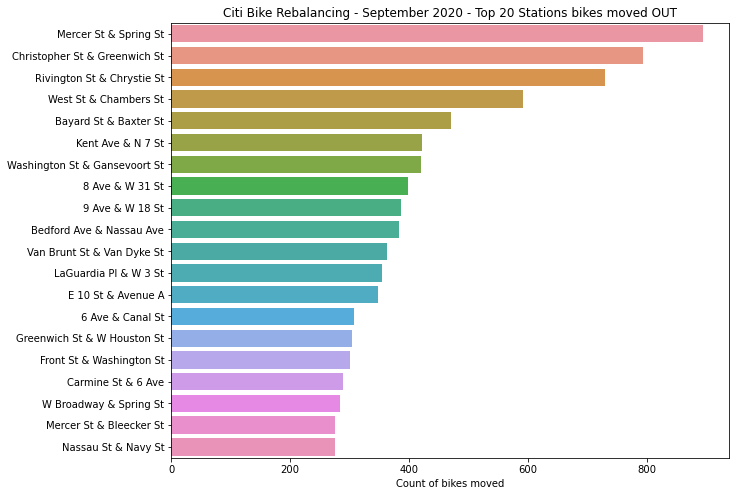

In [19]:
plt.figure(figsize=(10,8))
plt.title('Citi Bike Rebalancing - September 2020 - Top 20 Stations bikes moved OUT'  ) 
plt.xlabel('Count of bikes moved') 
sns.barplot( x=rebalout.values, y=rebalout.index,  orient="h" ) ;

In [20]:
rebalin = dfrebal['end station name'].value_counts()[:20]

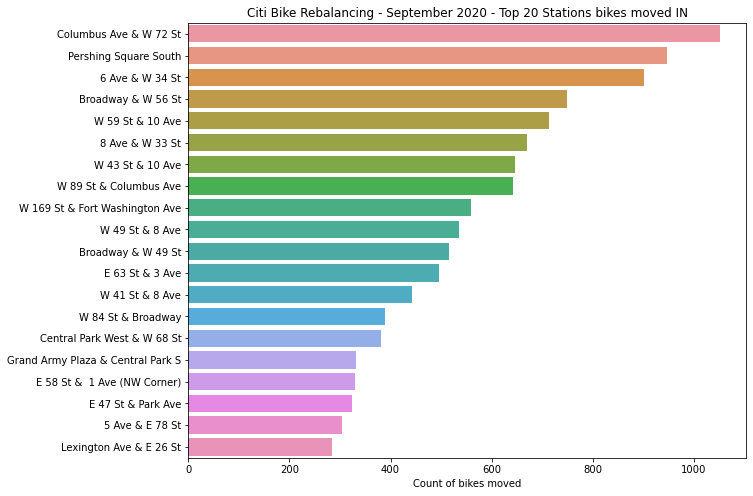

In [21]:
plt.figure(figsize=(10,8))
plt.title('Citi Bike Rebalancing - September 2020 - Top 20 Stations bikes moved IN'  ) 
plt.xlabel('Count of bikes moved') 
sns.barplot( x=rebalin.values , y=rebalin.index,  orient="h"  ) ;

### Rebalancing by Neighborhood
Read parquet file augmented with boro, neighboorhood and zip code for each station.  

This file was created by https://github.com/ckran/bikeshare/blob/main/locations.ipynb and can be downloaded from https://github.com/ckran/bikeshare/blob/main/202009-stations.parquet   

Note: to read a paquet file install pyarrow from a command line: 
`conda install pyarrow`

In [22]:
dfstations=pd.read_parquet('../bikeshare/202009-stations.parquet')

Recreate `dfrebal`

In [23]:
dfrebal = dfbike[['starttime','start station id','stoptime','end station id']].\
      loc[(dfbike.bikeid1==dfbike.bikeid2) & (dfbike['start station id'] != dfbike['end station id']) ] 
dfrebal.reset_index(drop=True, inplace=True)

Add Neightboorhood for both Start Station and End Station

In [24]:
dfrebal = pd.merge(dfrebal, dfstations[['station name','neighborhood']], how = 'left',\
               left_on='start station id', right_on='stationid')
dfrebal = pd.merge(dfrebal, dfstations[['station name','neighborhood']], how = 'left',\
               left_on='end station id', right_on='stationid')

Rename automatically generated column names

In [25]:
dfrebal.rename(columns = 
        {'station name_x':'start station name','station name_y':'end station name',\
         'neighborhood_x':'start neighborhood','neighborhood_y':'end neighborhood'}, inplace = True)

Create `rebalout` with top 20 neighborhoods 

In [26]:
rebalout = dfrebal['start neighborhood'].astype('str').value_counts()[:20]

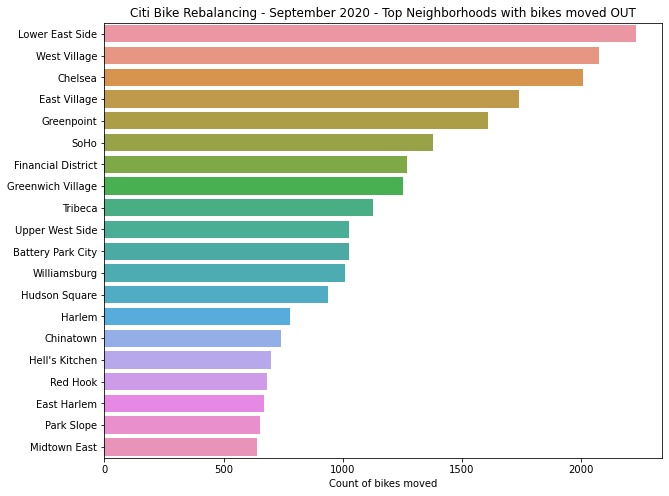

In [27]:
plt.figure(figsize=(10,8))
plt.title('Citi Bike Rebalancing - September 2020 - Top Neighborhoods with bikes moved OUT'  ) 
plt.xlabel('Count of bikes moved') 
sns.barplot( x=rebalout.values, y=rebalout.index,  orient="h" ) ;

In [28]:
rebalin = dfrebal['end neighborhood'].astype('str').value_counts()[:20]

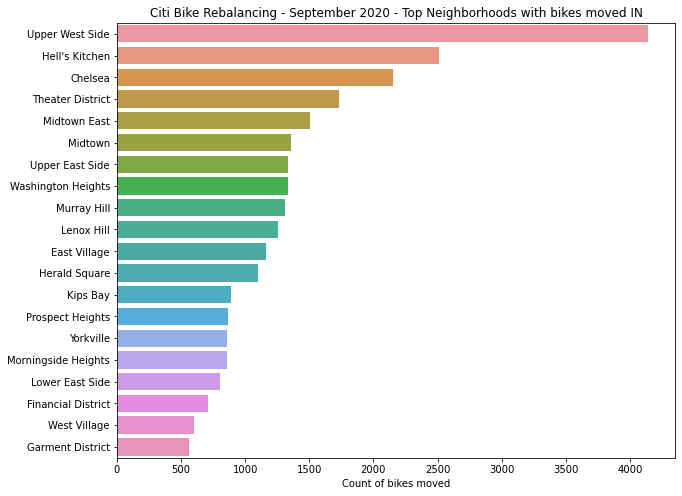

In [29]:
plt.figure(figsize=(10,8))
plt.title('Citi Bike Rebalancing - September 2020 - Top Neighborhoods with bikes moved IN'  ) 
plt.xlabel('Count of bikes moved') 
sns.barplot( x=rebalin.values, y=rebalin.index,  orient="h" ) ;

### Get Counts by the Hour

Add columns for start and end hour

In [30]:
dfrebal['starthour'],dfrebal['endhour'] = dfrebal.starttime.dt.hour, dfrebal.stoptime.dt.hour

View crosstabs table by station id and across hour of day 

In [31]:
pd.set_option('display.max_columns', 24)
dfrebal.groupby(['start station id', 'starthour']).size().unstack().astype('Int64').fillna(0).head(10)

starthour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
start station id,,,,,,,,,,,,,,,,,,,,,,,,
79,0,0,0,0,1,0,1,1,7,1,4,2,1,1,4,3,3,4,3,2,1,2,2,1
82,0,1,0,0,0,0,1,0,3,2,2,1,7,2,3,7,7,6,7,9,1,0,1,1
83,0,0,0,0,0,0,1,1,0,1,1,0,1,0,1,2,3,1,1,2,0,1,0,2
116,1,0,0,0,0,0,0,1,7,1,1,4,3,1,4,2,4,3,2,4,4,1,0,0
119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0
120,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,2,0,2,0,0,1,0
127,0,0,0,0,0,0,1,0,1,2,2,5,5,7,7,3,7,14,12,14,1,0,0,0
128,1,1,0,0,0,0,0,0,2,1,5,3,6,2,3,1,2,6,1,2,1,0,0,0
143,0,1,0,0,0,0,0,0,4,0,1,1,2,1,1,1,2,2,2,0,2,2,0,0


Aggregate the data to get a count of rides by station and by hour. 
Unstack and restack the data so that there is a count for ever hour of the day with a zero when there were no rides that hour.


In [32]:
dfrebal.value_counts(subset=['start station id', 'starthour']).unstack().astype('Int64').fillna(0).head(10)

starthour,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
start station id,,,,,,,,,,,,,,,,,,,,,,,,
79,0,0,0,0,1,0,1,1,7,1,4,2,1,1,4,3,3,4,3,2,1,2,2,1
82,0,1,0,0,0,0,1,0,3,2,2,1,7,2,3,7,7,6,7,9,1,0,1,1
83,0,0,0,0,0,0,1,1,0,1,1,0,1,0,1,2,3,1,1,2,0,1,0,2
116,1,0,0,0,0,0,0,1,7,1,1,4,3,1,4,2,4,3,2,4,4,1,0,0
119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0
120,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,1,2,0,2,0,0,1,0
127,0,0,0,0,0,0,1,0,1,2,2,5,5,7,7,3,7,14,12,14,1,0,0,0
128,1,1,0,0,0,0,0,0,2,1,5,3,6,2,3,1,2,6,1,2,1,0,0,0
143,0,1,0,0,0,0,0,0,4,0,1,1,2,1,1,1,2,2,2,0,2,2,0,0


In [33]:
startcounts=dfrebal.value_counts(subset=['start station id','starthour']).unstack().astype('Int64').fillna(0).stack()
startcounts=pd.DataFrame(startcounts).assign(Movement='Out')

endcounts=dfrebal.value_counts(subset=['end station id','endhour']).astype('Int64').unstack().fillna(0).stack()
endcounts=pd.DataFrame(endcounts).assign(Movement='In')

In [34]:
startcounts=dfrebal.groupby(['start station id', 'starthour']).size().unstack().astype('Int64').fillna(0).stack()
startcounts=pd.DataFrame(startcounts).assign(Movement='Out')

endcounts=dfrebal.groupby(['end station id', 'endhour']).size().astype('Int64').unstack().fillna(0).stack()
endcounts=pd.DataFrame(endcounts).assign(Movement='In')

Concatenate movments in and out into one dataframe 


In [35]:
rebalcounts=pd.concat([startcounts, endcounts])
rebalcounts.columns=['Bike Count','Movement']

In [36]:
def stationrebal (stationname):
    plt.figure(figsize=(12,5))
    if stationname not in list(dfstations['station name']):
        raise RuntimeError("Station name not found.")
    station=dfstations.loc[dfstations['station name']==stationname].index[0]
    plt.suptitle('Citi Bike Rebalanancing - ' +  stationname   )         
    ax= sns.barplot(data=rebalcounts.loc[station] ,  x=list(rebalcounts.loc[station].index),\
                y="Bike Count", hue="Movement" ,\
                palette=["darkred", "darkgreen"], edgecolor = 'w')  
    ax.set(xlabel="Hour of Day", ylabel = "Count of bikes moved"  ) ; 

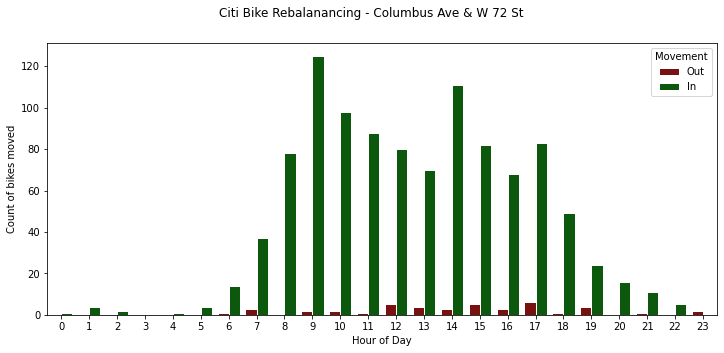

In [37]:
stationrebal('Columbus Ave & W 72 St')

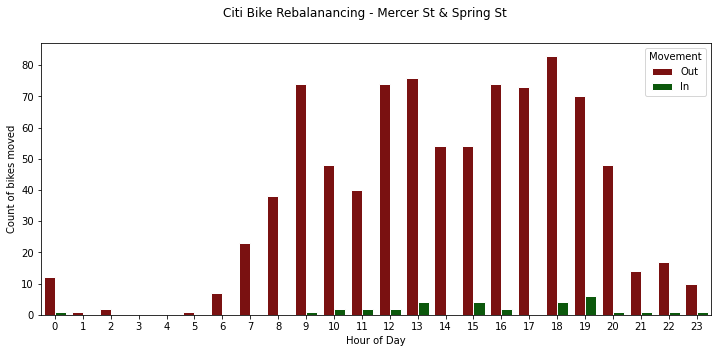

In [38]:
stationrebal('Mercer St & Spring St')